In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
import datatable
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 300
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

In [3]:
vars1 = datatable.fread('candidate_variables.csv')
vars_before = vars1.to_pandas()
vars_before.shape

(96397, 1424)

In [4]:
vars_before.head()

,Recnum,Fraud,Dow_Risk,state_risk,benford_Cardnum,benford_Merchnum,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,...,Merchnum_desc_count_1_by_60_sq,Card_Merchnum_desc_count_0_by_7_sq,Card_Merchnum_desc_count_0_by_14_sq,Card_Merchnum_desc_count_0_by_30_sq,Card_Merchnum_desc_count_0_by_60_sq,Card_Merchnum_desc_count_1_by_7_sq,Card_Merchnum_desc_count_1_by_14_sq,Card_Merchnum_desc_count_1_by_30_sq,Card_Merchnum_desc_count_1_by_60_sq,amount_cat
0,1,False,0.025994,0.007970,1.000894,1.000894,1461.0,1,3.62,3.62,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1
1,2,False,0.025994,0.003304,1.000894,1.000894,1461.0,1,31.42,31.42,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,2
2,3,False,0.025994,0.017282,1.000894,1.000894,1461.0,1,178.49,178.49,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3
3,4,False,0.025994,0.007970,1.000894,1.010684,1461.0,1,3.62,3.62,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1
4,5,False,0.025994,0.007970,1.010684,1.031246,0.0,2,3.62,3.62,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1


In [5]:
data=pd.read_csv('clean_card_transaction.csv',converters={'Merchnum': lambda x:str(x),'Cardnum':lambda x:str(x)})
data['Date']=pd.to_datetime(data.Date)
train_set=data[data.Date<'2010-11-01']
train_set.head(-10)
#data[data.Date>='2010-11-01'].head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...
83955,84285,5142219772,2010-10-31,6855293370648,PRESTIGE OFFICE PRODUCTS,NC,27705.0,P,179.98,0
83956,84286,5142159545,2010-10-31,465614280334,SCIENTIFIC RESOURCES,NJ,7724.0,P,57.99,0
83957,84287,5142202847,2010-10-31,6855293370648,PRESTIGE OFFICE PRODUCTS,NC,27705.0,P,203.59,0
83958,84288,5142205754,2010-10-31,6855293370648,PRESTIGE OFFICE PRODUCTS,NC,27705.0,P,93.86,0


## Run a filter on all the files

In [6]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    #df = df[df.index <= 84289] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables.csv size is (96397, 1424)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
candidate_variables.csv                        variable  filter score
0                         Fraud      1.000000
421           card_zip3_total_7      0.676549
229            card_zip_total_7      0.666816
412           card_zip3_total_3      0.660260
430          card_zip3_total_14      0.659257
238           card_zip_total_14      0.652244
220            card_zip_total_3      0.652217
165          card_merch_total_7      0.637702
247           card_zip_total_30      0.637171
419             card_zip3_max_7      0.630957
156          card_merch_total_3      0.630782
439          card_zip3_total_30      0.630295
174         card_merch_total_14      0.630048
428            card_zip3_max_14      0.629515
236             card_zip_max_14      0.627930
227              card_zip_max_7      0.625088
245             card_zip_max_30      0.624168
485      Card_Merch

In [7]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [8]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,card_zip3_total_7,0.676549
2,card_zip_total_7,0.666816
3,card_zip3_total_3,0.660260
4,card_zip3_total_14,0.659257
5,card_zip_total_14,0.652244
6,card_zip_total_3,0.652217
7,card_merch_total_7,0.637702
8,card_zip_total_30,0.637171
9,card_zip3_max_7,0.630957


In [9]:
filter_score.tail(10)

,variable,filter score
1414,card_merch_unique_count_for_zip3_7,0.000953
1415,Card_Merchdesc_unique_count_for_zip3_3,0.000888
1416,card_merch_unique_count_for_zip3_3,0.000823
1417,Card_Merchnum_desc_unique_count_for_zip3_7,0.000801
1418,Card_Merchdesc_unique_count_for_zip3_1,0.000704
1419,card_merch_unique_count_for_zip3_1,0.000693
1420,Card_Merchnum_desc_unique_count_for_zip3_3,0.000671
1421,Merchnum_desc_unique_count_for_zip3_3,0.000667
1422,Card_Merchnum_desc_unique_count_for_zip3_1,0.000585
1423,card_merch_unique_count_for_Cardnum_1,0.000000


In [10]:
filter_score.shape

(1424, 2)

In [11]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip3_total_7', 'card_zip_total_7', 'card_zip3_total_3', 'card_zip3_total_14', 'card_zip_total_14', 'card_zip_total_3', 'card_merch_total_7', 'card_zip_total_30', 'card_zip3_max_7', 'card_merch_total_3', 'card_zip3_total_30', 'card_merch_total_14', 'card_zip3_max_14', 'card_zip_max_14', 'card_zip_max_7', 'card_zip_max_30', 'Card_Merchdesc_total_7', 'card_zip_total_60', 'Card_Merchnum_desc_total_7', 'card_zip3_total_1', 'card_merch_total_30', 'card_zip3_max_30', 'Card_Merchdesc_total_14', 'Card_Merchnum_desc_total_14', 'card_zip3_total_60', 'card_zip_total_1', 'Card_Merchdesc_total_3', 'Card_Merchnum_desc_total_3', 'Card_Merchdesc_total_30', 'card_zip3_max_3', 'Card_Merchnum_desc_total_30', 'card_merch_max_14', 'card_zip_max_60', 'card_merch_max_30', 'Card_Merchdesc_max_14', 'card_merch_max_7', 'Card_Merchnum_desc_max_14', 'Card_Merchdesc_max_30', 'Card_Merchdesc_max_7', 'Card_Merchnum_desc_max_30', 'card_zip_max_3', 'card_merch_total_60', 'Card_Merchnum_desc_max_7',

In [12]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip3_total_7,card_zip_total_7,card_zip3_total_3,card_zip3_total_14,card_zip_total_14,card_zip_total_3,card_merch_total_7,card_zip_total_30,card_zip3_max_7,card_merch_total_3,...,zip3_med_1,Merchnum_variability_avg_30,card_zip_count_7,zip3_avg_3,merch_zip_variability_avg_30,Cardnum_count_14,zip3_actual/max_14,zip3_actual/med_7,card_zip3_actual/toal_3,card_zip3_day_since
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,1023.04,174.20,1023.04,1023.04,174.20,1023.04,1023.04,792.26,174.20,...,174.20,88.271081,3,396.481250,88.271081,21,0.070958,1.360937,1.000000,6.0
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,369.81,-73.333333,1,441.489333,-73.333333,8,0.105485,1.429184,1.000000,1474.0
2997,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,53.88,76.85,...,40.02,187.681765,2,203.210625,187.681765,5,0.049089,1.147604,0.701106,2.0
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,80.70,-347.317241,1,600.411818,-347.317241,6,0.271967,5.890681,1.000000,1474.0
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,295.40,156.720000,1,379.987600,156.720000,6,0.119759,0.838290,1.000000,1474.0


In [13]:
df_keep.shape

(93409, 300)

In [14]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [15]:
Y = Y.copy()                                      # Create copy of DataFrame
Y = Y.astype(int)
print(Y)

        Fraud
Recnum       
2995        0
2996        0
2997        0
2998        0
2999        0
...       ...
96749       0
96750       0
96751       0
96752       0
96753       0

[93409 rows x 1 columns]


In [16]:
Y = Y.values
Y_save = Y.copy()

In [17]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [18]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:27.361003


In [19]:
print(X.shape,Y.shape)

(93409, 300) (93409, 1)


In [20]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [21]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [22]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [23]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=4) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

Wall time: 5min 59s


SequentialFeatureSelector(cv=3,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=4),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x000001747CBC6700>)

In [24]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:06:26.575304


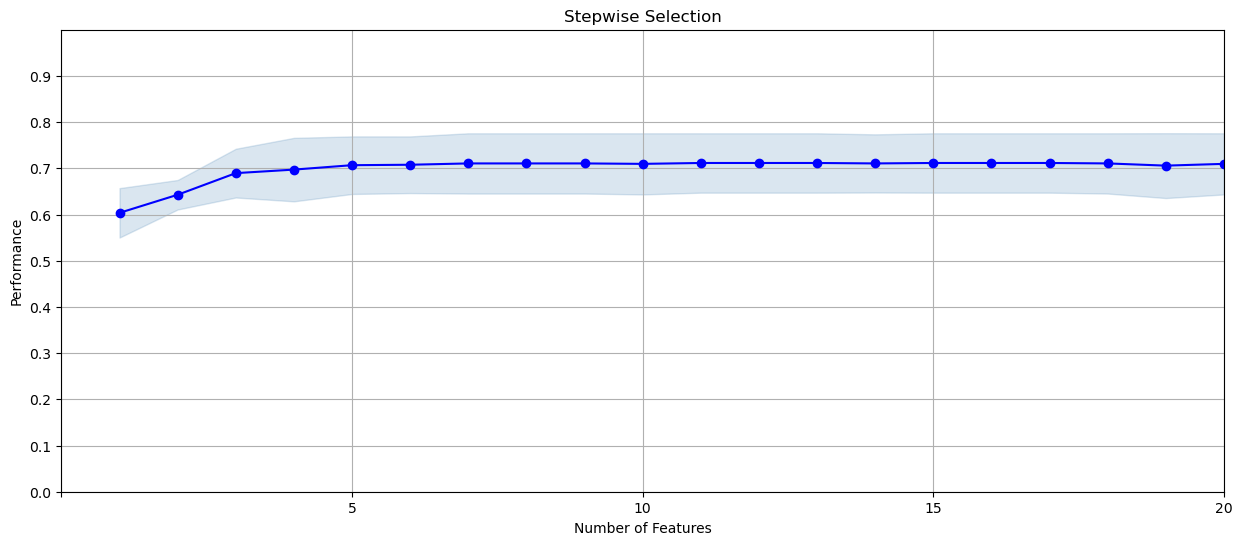

In [25]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [26]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [27]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [28]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(4,)","[0.6790830945558739, 0.5616045845272206, 0.570...",0.603629,"(card_zip_total_14,)",0.120323,0.053469,0.037808,1.0,card_zip_total_14
2,"(4, 21)","[0.6848137535816619, 0.6361031518624641, 0.607...",0.642789,"(card_zip_total_14, card_zip3_max_30)",0.071865,0.031936,0.022582,2.0,card_zip3_max_30
3,"(4, 21, 70)","[0.7564469914040115, 0.6848137535816619, 0.627...",0.689589,"(card_zip_total_14, card_zip3_max_30, Card_Mer...",0.1187,0.052748,0.037298,3.0,Card_Merchnum_desc_total_0
4,"(4, 21, 49, 70)","[0.7879656160458453, 0.6819484240687679, 0.621...",0.69723,"(card_zip_total_14, card_zip3_max_30, card_zip...",0.154601,0.068702,0.048579,4.0,card_zip3_max_60
5,"(4, 21, 41, 49, 70)","[0.7908309455587392, 0.6876790830945558, 0.641...",0.706781,"(card_zip_total_14, card_zip3_max_30, card_mer...",0.140217,0.062309,0.044059,5.0,card_merch_total_60
6,"(4, 21, 32, 41, 49, 70)","[0.7908309455587392, 0.6876790830945558, 0.644...",0.707736,"(card_zip_total_14, card_zip3_max_30, card_zip...",0.137992,0.061321,0.04336,6.0,card_zip_max_60
7,"(4, 21, 32, 41, 48, 49, 70)","[0.7994269340974212, 0.6876790830945558, 0.644...",0.710602,"(card_zip_total_14, card_zip3_max_30, card_zip...",0.146753,0.065214,0.046113,7.0,Card_Merchnum_desc_max_60
8,"(4, 7, 21, 32, 41, 48, 49, 70)","[0.7994269340974212, 0.6876790830945558, 0.644...",0.710602,"(card_zip_total_14, card_zip_total_30, card_zi...",0.146753,0.065214,0.046113,8.0,card_zip_total_30
9,"(4, 7, 21, 32, 41, 48, 49, 70, 132)","[0.7994269340974212, 0.6876790830945558, 0.644...",0.710602,"(card_zip_total_14, card_zip_total_30, card_zi...",0.146753,0.065214,0.046113,9.0,card_merch_avg_0
10,"(4, 7, 21, 24, 32, 41, 48, 49, 70, 132)","[0.7994269340974212, 0.6876790830945558, 0.641...",0.709647,"(card_zip_total_14, card_zip_total_30, card_zi...",0.14894,0.066186,0.0468,10.0,card_zip3_total_60


In [29]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [30]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1              card_zip_total_14
2               card_zip3_max_30
3     Card_Merchnum_desc_total_0
4               card_zip3_max_60
5            card_merch_total_60
6                card_zip_max_60
7      Card_Merchnum_desc_max_60
8              card_zip_total_30
9               card_merch_avg_0
10            card_zip3_total_60
11                    zip3_avg_0
12        Card_Merchdesc_total_0
13            zip3_actual/max_60
14     Card_Merchnum_desc_max_30
15                    amount_cat
16               card_zip3_avg_0
17                card_zip_avg_0
18           Merchnum_desc_med_0
19           Merchnum_desc_avg_0
20           Merchnum_desc_avg_1
Name: variable name, dtype: object

In [31]:
ordered_vars_FS['variable name']

1              card_zip_total_14
2               card_zip3_max_30
3     Card_Merchnum_desc_total_0
4               card_zip3_max_60
5            card_merch_total_60
6                card_zip_max_60
7      Card_Merchnum_desc_max_60
8              card_zip_total_30
9               card_merch_avg_0
10            card_zip3_total_60
11                    zip3_avg_0
12        Card_Merchdesc_total_0
13            zip3_actual/max_60
14     Card_Merchnum_desc_max_30
15                    amount_cat
16               card_zip3_avg_0
17                card_zip_avg_0
18           Merchnum_desc_med_0
19           Merchnum_desc_avg_0
20           Merchnum_desc_avg_1
Name: variable name, dtype: object

In [32]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
card_zip3_total_7,0.676549
card_zip_total_7,0.666816
card_zip3_total_3,0.660260
card_zip3_total_14,0.659257
card_zip_total_14,0.652244
...,...
card_merch_unique_count_for_zip3_1,0.000693
Card_Merchnum_desc_unique_count_for_zip3_3,0.000671
Merchnum_desc_unique_count_for_zip3_3,0.000667


In [33]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
card_zip_total_14
card_zip3_max_30
Card_Merchnum_desc_total_0
card_zip3_max_60
card_merch_total_60


In [34]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [35]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,card_zip_total_14,0.652244
1,2,card_zip3_max_30,0.614513
2,3,Card_Merchnum_desc_total_0,0.538083
3,4,card_zip3_max_60,0.584736
4,5,card_merch_total_60,0.598597
5,6,card_zip_max_60,0.605193
6,7,Card_Merchnum_desc_max_60,0.586123
7,8,card_zip_total_30,0.637171
8,9,card_merch_avg_0,0.512411
9,10,card_zip3_total_60,0.611354


In [36]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_zip_total_14',
 'card_zip3_max_30',
 'Card_Merchnum_desc_total_0',
 'card_zip3_max_60',
 'card_merch_total_60',
 'card_zip_max_60',
 'Card_Merchnum_desc_max_60',
 'card_zip_total_30',
 'card_merch_avg_0',
 'card_zip3_total_60',
 'zip3_avg_0',
 'Card_Merchdesc_total_0',
 'zip3_actual/max_60',
 'Card_Merchnum_desc_max_30',
 'amount_cat',
 'card_zip3_avg_0',
 'card_zip_avg_0',
 'Merchnum_desc_med_0',
 'Merchnum_desc_avg_0',
 'Merchnum_desc_avg_1',
 'Recnum',
 'Fraud']

In [37]:
filter_score

,filter score
variable,
card_zip3_total_7,0.676549
card_zip_total_7,0.666816
card_zip3_total_3,0.660260
card_zip3_total_14,0.659257
card_zip_total_14,0.652244
...,...
card_merch_unique_count_for_zip3_1,0.000693
Card_Merchnum_desc_unique_count_for_zip3_3,0.000671
Merchnum_desc_unique_count_for_zip3_3,0.000667


In [38]:
%%time
df = pd.read_csv(file_name)
df.shape

Wall time: 11.2 s


(96397, 1424)

In [39]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(96397, 22)


In [40]:
df_keep.to_csv('vars_final.csv',index=False)

In [41]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:06:38.940715
